# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам


## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import seaborn as sns
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.3


In [5]:
def mape(y_true, y_pred, log_price=False):
    if log_price == False:
        return np.mean(np.abs((y_pred-y_true)/y_true))
    else:
        return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [11]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
bodyType,6682,17,седан,2843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand,6682,3,BMW,2805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,6682,16,чёрный,2805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,6682,6147,Выгода до 82 000 руб. при обмене на Ваш автомо...,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
engineDisplacement,6682,48,2.0 LTR,1929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enginePower,6682,146,184 N12,602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuelType,6682,4,бензин,4804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,6682,NaN,NaN,NaN,120523,81454.4,1,59181.2,111000,168000,999999
modelDate,6682,NaN,NaN,NaN,2010.14,5.37097,1975,2007,2011,2014,2019
model_info,6682,118,5ER,611,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ШАГ 1:  Строим «наивную» ML-модель на табличных данных, которая предсказывает цену по модели и году выпуска. Это позволит нам задать направление для дальнейших экспериментов. C ней будем сравнивать другие модели.

In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


## Точность наивной модели по метрике MAPE: 19.88% - на leaderboard проверять нет смысла

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

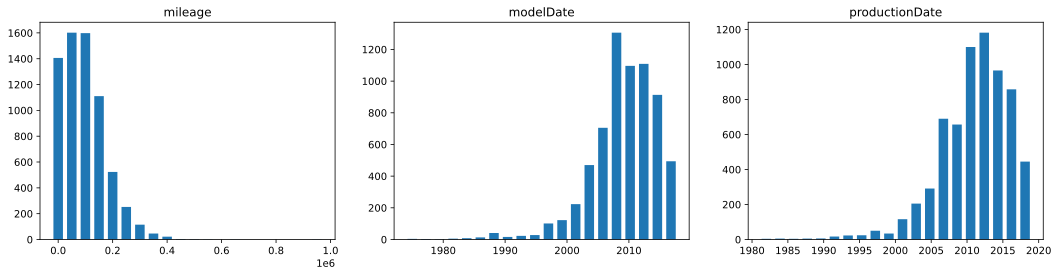

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [15]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # владельцы
    df_output['Владельцы'] = df_output['Владельцы'].apply(lambda x: str(x).split()[0])
    
        # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
      
    
    # ################### Feature Engineering ####################################################
    
    CURR_YEAR = 2021
    def calc_eng_power_2_user(row):
        n=3
        if row['Владельцы']=='3 или более': n=3
        if row['Владельцы']=='1 владелец': n=1
        if row['Владельцы']=='2 владельца': n=2
            
        return round(row['enginePowerD']/n,0) 
    
    def calc_km_per_year(row):
        if CURR_YEAR - row ['productionDate'] > 0:
            return row['mileage'] /  CURR_YEAR - row['productionDate']
        else:
            return row['mileage']
        
    def calc_enginePower2liter(row):
        if row ['engineDisplacement'] != 0:
            return np.log(row['enginePowerD'] / (row['engineDisplacement']) )
        else:
            return np.log(row['enginePowerD'])
        
    df_output['enginePowerD'] = df_output['enginePower']        
    #пробег за год    
    df_output['km_per_year'] = df_output.apply(calc_km_per_year, axis=1) 

    
    # enginePower в число
    kvt_filter = df_output['enginePowerD'].str.contains('\xa0кВт') #1.35962
    df_output['enginePowerD'] = df_output['enginePowerD'].str.replace(' N12','')
    df_output['enginePowerD'] = df_output['enginePowerD'].str.replace('\xa0кВт','')
    df_output['enginePowerD'] = df_output['enginePowerD'].astype('int32')
    df_output[kvt_filter]['enginePowerD'] = round(df_output[kvt_filter]['enginePowerD'] * 1.35962,0)# электрокары привели к ДВС
    
    #Потеря мощности от пробега
    df_output['km_per_year_power'] = np.log((df_output['enginePowerD'] / ( df_output['mileage']/15000))  *  (CURR_YEAR - df_output['productionDate']))
    
    df_output.loc[df_output['fuelType'] == 'электро','engineDisplacement'] = '0 LTR' # электрокары привели к ДВС
    df_output['engineDisplacement'] = df_output['engineDisplacement'].str.replace(' LTR','').astype('float')
      
    #modelDate -- productionDate
    df_output['modelDate'] = np.log(CURR_YEAR - df_output['modelDate'])
    df_output['productionDate'] = np.log(CURR_YEAR - df_output['productionDate'])
    df_output['mileage'] = np.log(df_output['mileage'])
    df_output['sell_id1'] = np.log(df_output['sell_id'])
    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(-1,1))

    numerical_features.extend(['km_per_year','km_per_year_power','sell_id1', 'enginePowerD', 'engineDisplacement'])

    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
     # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать или недостаточно полные  
    drop_me = ['description','Владение','vehicleConfiguration', 'enginePower', 'name','sell_id']
    df_output.drop(drop_me, axis = 1, inplace=True)
    
    def calc_price_log(row):
        if row['sample'] == 1:
            return np.log(row['price'])
        else:
            return 0
    df_output['price'] = df_output.apply(calc_price_log, axis=1)
    return df_output

In [18]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)

In [19]:
df_preproc.sample(10)

,engineDisplacement,mileage,modelDate,productionDate,sample,price,enginePowerD,km_per_year,km_per_year_power,sell_id1,...,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,-0.393939,0.676461,-2.216146e-01,-0.021848,1,14.279245,-0.4560,-0.777484,-0.710482,0.995321,...,0,0,0,0,1,0,0,1,1,0
4273,-0.393939,0.551071,-1.386469e-01,-0.121381,1,14.946913,-0.4560,-0.899134,-0.601973,0.999385,...,0,0,0,0,1,0,0,1,1,0
3362,0.666667,0.580121,-1.386469e-01,-0.021848,1,15.137266,0.6320,-0.876292,-0.466782,0.997040,...,0,1,0,0,1,0,0,1,1,0
2794,-0.090909,0.698970,2.220446e-16,0.257020,1,14.503645,-0.4560,-0.727920,-0.654099,0.987264,...,0,1,0,0,1,0,0,1,1,0
5378,-0.393939,0.724395,-1.386469e-01,-0.021848,1,14.066269,-0.5424,-0.697678,-0.781549,0.999741,...,0,1,0,0,1,0,0,1,1,0
5902,0.212121,0.614618,-6.546417e-02,0.135202,1,15.039286,0.5520,-0.840489,-0.465876,0.992604,...,0,0,0,0,1,0,0,1,1,0
1454,-0.090909,0.574118,-6.546417e-02,-0.021848,0,0.000000,-0.2160,-0.880537,-0.555929,0.999485,...,1,0,0,0,1,0,0,1,1,0
2476,-0.242424,0.746433,2.090620e-01,0.400249,1,13.458836,-0.5424,-0.624242,-0.683019,0.995818,...,0,1,0,1,0,1,0,0,1,0
743,-0.515152,0.693060,2.090620e-01,0.309051,0,0.000000,-0.8720,-0.733581,-0.752508,0.989532,...,0,1,0,0,1,1,0,0,1,0
1168,0.666667,0.518768,-6.546417e-02,0.062305,0,0.000000,0.5008,-0.908555,-0.386603,0.998046,...,0,1,0,0,1,0,0,1,1,0


In [20]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 191 entries, engineDisplacement to Руль_1
dtypes: float64(9), int64(1), uint8(181)
memory usage: 2.1 MB


In [21]:
df_preproc.columns

Index(['engineDisplacement', 'mileage', 'modelDate', 'productionDate',
       'sample', 'price', 'enginePowerD', 'km_per_year', 'km_per_year_power',
       'sell_id1',
       ...
       'Владельцы_1', 'Владельцы_2', 'Владельцы_3', 'ПТС_0', 'ПТС_1',
       'Привод_0', 'Привод_1', 'Привод_2', 'Руль_0', 'Руль_1'],
      dtype='object', length=191)

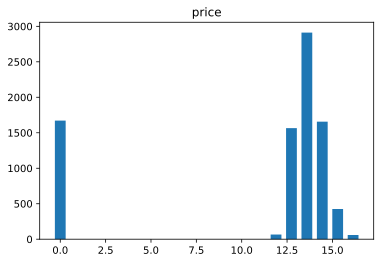

In [22]:
# Прологарифмировали цену - получили нормальное распределение
visualize_distributions({
    'price': df_preproc['price']})

# Шаг 2. Обработали и отнормировали признаки. 
Feature Engenearing:
 - Связали productionDate и modelDate c 2021 и прологарифмировали
 - В enginePower собрали все типы двигателей, включая электро
 - engineDisplacement - преобразовали в число
 - новый признак km_per_year - средний пробег за год
 - новый признак km_per_year_power - потеря мощности от пробега
 - mileage - прологарифмировали для придания нормального распределения
 - sell_id - прологарифмировали 
 - Численные признаки отнормировали 
 - категориальные признаки закодировали OneHotEncoding
 - price прологарифмировали 
 - остальные признаки удалили

## Split data

In [23]:
def price_exp_and_round(predicts, log_price=False, round_ = 25000 ):
    '''
    Развернем log в рубли
    Округлим  до 25000р
    '''
    #round_ = round_1#25000# 25000
    if log_price==True:
        predicts = np.exp(predicts)
    predicts = (predicts // round_) * round_
    return predicts

In [24]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 190 entries, engineDisplacement to Руль_1
dtypes: float64(9), uint8(181)
memory usage: 425.9 KB


# Model 2: CatBoostRegressor

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [27]:
# цена в обычном виде
y_train_1 = np.exp(y_train)
y_test_1 = np.exp(y_test)

In [28]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.8, random_state=RANDOM_SEED)
    train_pool = Pool(train_x, train_y)
    test_pool = Pool(test_x, test_y)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 1000),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    MAPE = mape(test_y, pred_labels)
    return MAPE

In [29]:
#import optuna
#if __name__ == '__main__':
#    study = optuna.create_study()
#    study.optimize(objective, n_trials=3)
   #print(study.best_trial)

In [30]:
#study.best_params

In [31]:
model = CatBoostRegressor(iterations =4000,
                          #depth=5,
                          #learning_rate = 0.26,
                          random_seed = RANDOM_SEED,
                          #random_strength = 55,
                          #bagging_temperature = 9,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #od_type = 'IncToDec',
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.026975
0:	learn: 0.0417634	test: 0.0418138	best: 0.0418138 (0)	total: 51ms	remaining: 3m 23s
100:	learn: 0.0122617	test: 0.0120014	best: 0.0120014 (100)	total: 409ms	remaining: 15.8s
200:	learn: 0.0102612	test: 0.0100419	best: 0.0100419 (200)	total: 753ms	remaining: 14.2s
300:	learn: 0.0096678	test: 0.0095294	best: 0.0095294 (300)	total: 1.09s	remaining: 13.4s
400:	learn: 0.0093047	test: 0.0092427	best: 0.0092420 (399)	total: 1.42s	remaining: 12.8s
500:	learn: 0.0088969	test: 0.0089732	best: 0.0089732 (500)	total: 1.76s	remaining: 12.3s
600:	learn: 0.0085015	test: 0.0087159	best: 0.0087159 (600)	total: 2.1s	remaining: 11.9s
700:	learn: 0.0081755	test: 0.0084770	best: 0.0084764 (698)	total: 2.44s	remaining: 11.5s
800:	learn: 0.0079046	test: 0.0083283	best: 0.0083281 (799)	total: 2.79s	remaining: 11.1s
900:	learn: 0.0076929	test: 0.0082035	best: 0.0082035 (900)	total: 3.12s	remaining: 10.7s
1000:	learn: 0.0075450	test: 0.0081452	best: 0.0081449 (999)	total: 3.46s	r

In [32]:
test_predict_catboost = model.predict(X_test)
test_predict_catboost = price_exp_and_round(test_predict_catboost, log_price=True)
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_catboost, log_price=False))*100:0.2f}%")

TEST mape: 11.13%


# Шаг 3.  Сделали первую модель на основе градиентного бустинга с помощью CatBoost. Результат на тесте показал 11.13% не плохо, на лидерборде пока проверять не будем

### Submission

In [33]:
sub_predict_catboost = model.predict(X_sub)
sub_predict_catboost = price_exp_and_round(sub_predict_catboost, log_price=True)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

## Шаг 4. Решим эту же задачу с помощью DL (модель NN Tabular) и сравним результаты

Построим обычную сеть:

In [34]:
X_train.head(5)

,engineDisplacement,mileage,modelDate,productionDate,enginePowerD,km_per_year,km_per_year_power,sell_id1,bodyType_0,bodyType_1,...,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.818182,0.725364,1.630161e-01,0.257020,0.5008,-0.680417,-0.556455,0.999741,0,0,...,0,0,0,0,1,1,0,0,1,0
8037,-0.393939,0.440339,-4.306766e-01,-0.400249,-0.4560,-0.952528,-0.561657,0.999795,0,1,...,0,0,0,0,1,0,0,1,1,0
4681,-0.060606,0.708924,3.296979e-01,0.478370,-0.4240,-0.691814,-0.594324,0.999918,0,0,...,0,1,0,0,1,0,0,1,1,0
6014,-0.454545,0.839505,2.519296e-01,0.440706,-0.6512,-0.323028,-0.800179,0.998079,0,0,...,0,1,0,0,1,1,0,0,1,0
3649,-0.090909,0.700124,2.220446e-16,0.135202,-0.2384,-0.733701,-0.651904,0.999865,0,0,...,0,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [35]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())

model.add(L.Dense(512, kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.BatchNormalization())

model.add(L.Dense(256, kernel_initializer='lecun_normal', activation="relu"))
model.add(L.Dropout(0.5))


model.add(L.Dense(1, activation="linear"))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               97280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [37]:
# Compile model

optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor='val_MAPE', verbose=1  , mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor='val_MAPE', patience=70, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [39]:
history = model.fit(X_train, y_train_1,
                    batch_size=256,
                    epochs=700, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test_1),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/700
16/23 [===================>..........] - ETA: 0s - loss: 99.9999 - MAPE: 99.9999  
Epoch 00001: val_MAPE improved from inf to 99.99985, saving model to ../working/best_model.hdf5
23/23 [==============================] - 0s 15ms/step - loss: 99.9998 - MAPE: 99.9998 - val_loss: 99.9998 - val_MAPE: 99.9998
Epoch 2/700
17/23 [=====================>........] - ETA: 0s - loss: 99.9988 - MAPE: 99.9988
Epoch 00002: val_MAPE improved from 99.99985 to 99.99818, saving model to ../working/best_model.hdf5
23/23 [==============================] - 0s 7ms/step - loss: 99.9983 - MAPE: 99.9983 - val_loss: 99.9982 - val_MAPE: 99.9982
Epoch 3/700
14/23 [=================>............] - ETA: 0s - loss: 99.9917 - MAPE: 99.9917
Epoch 00003: val_MAPE improved from 99.99818 to 99.98997, saving model to ../working/best_model.hdf5
23/23 [==============================] - 0s 9ms/step - loss: 99.9886 - MAPE: 99.9886 - val_loss: 99.9900 - val_MAPE: 99.9900
Epoch 4/700
20/23 [=========================>

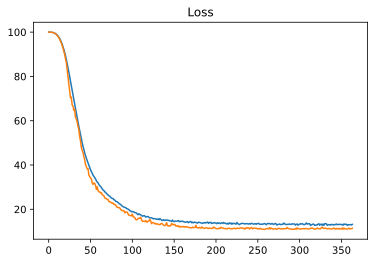

In [40]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [41]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [42]:
test_predict_nn1 = model.predict(X_test)

print(f"TEST mape: {(mape(y_test_1, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 10.96%


In [43]:
sub_predict_nn1 = model.predict(X_sub)
sub_predict_nn1 = price_exp_and_round(sub_predict_nn1[:,0],log_price=False, round_=10000)
sample_submission['price'] = sub_predict_nn1
sample_submission.to_csv('nn1_submission.csv', index=False)

## Тест МАРЕ 10.96% уже очень хорошо, но не будем торопиться с лидербордом, переходим к следующему шагу

## Переходим к шагу 5, NLP & Multiple Inputs

In [44]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [45]:
!pip install pymorphy2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [46]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

In [47]:
patterns = r"[A-Za-z0-9^\W]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens

In [48]:
%%time
data.description = data.description.apply(lemmatize)

CPU times: user 3min 11s, sys: 51.1 ms, total: 3min 11s
Wall time: 3min 11s


In [49]:
data.description

0       [весь, привет, продать, эксклюзивный, проект, ...
1       [продавать, любимый, тачил, обвес, тюнинг, пот...
2       [машина, продаваться, первый, но, только, пере...
3       [автомобиль, отличный, состояние, весь, родный...
4       [немка, бесключивый, доступ, камера, задний, в...
                              ...                        
8348    [продаваться, любимый, автомобиль, за, год, эк...
8349    [купить, официальный, дилер, г, третий, владел...
8350    [торг, место, всё, работать, сборка, немецкий,...
8351    [автомобиль, отличный, состояние, авто, семья,...
8352    [удлинённый, заводский, база, вообще, правильн...
Name: description, Length: 8353, dtype: object

In [50]:
from collections import defaultdict

In [51]:
word_freq = defaultdict(int)
for tokens in data.description.dropna():
    for token in tokens:
        word_freq[token] += 1

In [52]:
len(word_freq)

13617

In [53]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['автомобиль',
 'система',
 'пробег',
 'задний',
 'салон',
 'сидение',
 'год',
 'состояние',
 'передний',
 'машина']

In [54]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [55]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [56]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 663 ms, sys: 24 ms, total: 687 ms
Wall time: 686 ms


In [57]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'салон': 5,
 'сидение': 6,
 'год': 7,
 'состояние': 8,
 'передний': 9,
 'машина': 10,
 'диск': 11,
 'комплект': 12,
 'в': 13,
 'дилер': 14,
 'новый': 15,
 'официальный': 16,
 'ваш': 17,
 'кредит': 18,
 'фара': 19,
 'авто': 20,
 'гарантия': 21,
 'пакет': 22,
 'руль': 23,
 'всё': 24,
 'колесо': 25,
 'безопасность': 26,
 'комплектация': 27,
 'вы': 28,
 'обмен': 29,
 'птс': 30,
 'контроль': 31,
 'зеркало': 32,
 'проверка': 33,
 'покупка': 34,
 'продажа': 35,
 'водитель': 36,
 'полный': 37,
 'шина': 38,
 'датчик': 39,
 'км': 40,
 'отличный': 41,
 'пассажир': 42,
 'двигатель': 43,
 'резина': 44,
 'условие': 45,
 'владелец': 46,
 'ключ': 47,
 'то': 48,
 'кузов': 49,
 'подушка': 50,
 'подогрев': 51,
 'обогрев': 52,
 'технический': 53,
 'любой': 54,
 'обслуживание': 55,
 'хороший': 56,
 'два': 57,
 'юридический': 58,
 'оригинал': 59,
 'стекло': 60,
 'торг': 61,
 'масло': 62,
 'м': 63,
 'дверь': 64,
 'замена': 65,
 'чёрный': 66,
 'про

In [58]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 539 ms, sys: 752 µs, total: 540 ms
Wall time: 540 ms


In [59]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

['автомобиль', 'проверить', 'пункт', 'автокредит', 'специальный', 'ставка', 'ауди', 'центр', 'север', 'официальный', 'дилер', 'входящий', 'группа', 'компания', 'рольф', 'являться', 'один', 'крупный', 'дилер', 'европа', 'предлагать', 'вы', 'ряд', 'услуга', 'покупка', 'продажа', 'автомобиль', 'пробег', 'на', 'протяжение', 'многий', 'год', 'наш', 'дилерский', 'центр', 'являться', 'лидер', 'продажа', 'автомобиль', 'пробег', 'среди', 'дилер', 'россия', 'предоставлять', 'клиент', 'самый', 'большой', 'выбор', 'автомобиль', 'пробег', 'другой', 'марка', 'каждый', 'автомобиль', 'проходить', 'тщательный', 'диагностик', 'подготовка', 'гарантировать', 'находиться', 'отличный', 'состояние', 'чтобы', 'убедиться', 'правильный', 'выбор', 'вы', 'возможность', 'пройти', 'тест', 'драйв', 'ознакомительный', 'поездка', 'интересовать', 'автомобиль', 'вы', 'смочь', 'ознакомиться', 'автомобиль', 'выходить', 'дом', 'наш', 'менеджер', 'провести', 'презентация', 'видеозвонок', 'показать', 'выбрать', 'автомобиль',

# RNN NLP

In [60]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

# MLP

In [61]:
model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [62]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)#64
head = L.Dropout(0.1)(head)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [63]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3486208     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [64]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [65]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [66]:
%%time
history = model.fit([text_train_sequences, X_train], y_train_1,
                     batch_size=512,
                     epochs=200, # фактически мы обучаем пока EarlyStopping не остановит обучение
                     validation_data=([text_test_sequences, X_test], y_test_1),
                     callbacks=callbacks_list
                    )


Epoch 1/200
12/12 [==============================] - 3s 286ms/step - loss: 99.9567 - MAPE: 99.9567 - val_loss: 99.4466 - val_MAPE: 99.4466
Epoch 2/200
12/12 [==============================] - 3s 233ms/step - loss: 94.7119 - MAPE: 94.7119 - val_loss: 75.9959 - val_MAPE: 75.9959
Epoch 3/200
12/12 [==============================] - 3s 227ms/step - loss: 59.2898 - MAPE: 59.2898 - val_loss: 55.0101 - val_MAPE: 55.0101
Epoch 4/200
12/12 [==============================] - 3s 224ms/step - loss: 50.0065 - MAPE: 50.0065 - val_loss: 47.6770 - val_MAPE: 47.6770
Epoch 5/200
12/12 [==============================] - 3s 226ms/step - loss: 45.0574 - MAPE: 45.0574 - val_loss: 42.0920 - val_MAPE: 42.0920
Epoch 6/200
12/12 [==============================] - 3s 224ms/step - loss: 40.8657 - MAPE: 40.8657 - val_loss: 37.6975 - val_MAPE: 37.6975
Epoch 7/200
12/12 [==============================] - 3s 221ms/step - loss: 37.1159 - MAPE: 37.1159 - val_loss: 34.5891 - val_MAPE: 34.5891
Epoch 8/200
12/12 [========

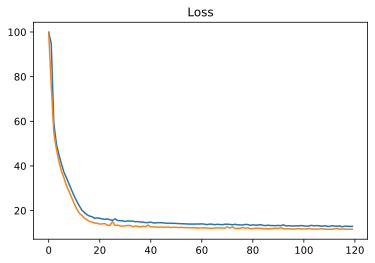

In [67]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [68]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [69]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test_1, test_predict_nn2[:,0]))*100:0.2f}%")

test_predict_nn2 = model.predict([text_test_sequences, X_test])
test_predict_nn2_1 = price_exp_and_round(test_predict_nn2[:,0],log_price=False, round_=1)
print(f"TEST mape: {(mape(y_test_1, test_predict_nn2_1, log_price=False))*100:0.2f}%")

TEST mape: 11.68%
TEST mape: 11.68%


In [70]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

## Результат получили хуже 11.68% Прямое использование этих фичей не дает значимого разультата.

# Шаг 6, добавляем картинки

### Data

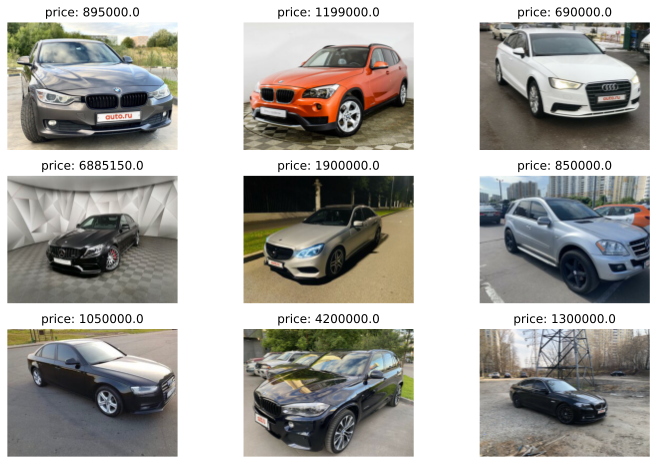

In [71]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [72]:
size = (224,224) #(320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 224, 224, 3) dtype uint8
images shape (1003, 224, 224, 3) dtype uint8
images shape (1671, 224, 224, 3) dtype uint8


### albumentations

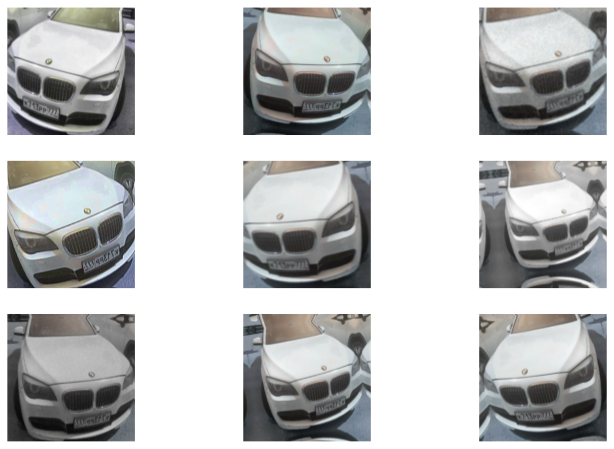

In [73]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [74]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [75]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_text(text):
    return text

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    print(text)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, text_train_sequences, y_train_1
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, text_test_sequences, y_test_1
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Tensor("args_2:0", shape=(256,), dtype=int32)


### Строим сверточную сеть для анализа изображений без "головы"

In [76]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [77]:
tabular_model = Sequential()
tabular_model.add(L.Dense(512, input_dim=X_train.shape[1], kernel_initializer='lecun_normal', activation="relu"))
tabular_model.add(L.Dropout(0.5)) #0.5

tabular_model.add(L.Dense(512, kernel_initializer='lecun_normal', activation="relu"))
tabular_model.add(L.Dropout(0.5))

tabular_model.add(L.Dense(256, kernel_initializer='lecun_normal', activation="relu"))
tabular_model.add(L.Dropout(0.5))

In [78]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [79]:
BATCH_SIZE = 16
EPOCHS = 500
PATIENCE = 10
CHECKPOINT_FILEPATH = 'best_model.hdf5'
MONITOR = 'val_MAPE'
LOSS = 'MAPE'
MODE = 'min'
LR = 1e-3
FINAL_LR = 0.1

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()



Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [80]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [81]:
checkpoint = ModelCheckpoint(CHECKPOINT_FILEPATH, monitor='val_MAPE', verbose=1, mode='min', save_best_only=True)
earlystop = EarlyStopping(monitor=MONITOR, patience=PATIENCE, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [82]:
history = model.fit(train_dataset.batch(8),
                    epochs=8,
                    validation_data = test_dataset.batch(8),
                    callbacks=callbacks_list
                   )

Epoch 1/8
710/710 [==============================] - ETA: 0s - loss: 29.6053 - MAPE: 29.6053
Epoch 00001: val_MAPE improved from inf to 17.50570, saving model to best_model.hdf5
710/710 [==============================] - 138s 195ms/step - loss: 29.6053 - MAPE: 29.6053 - val_loss: 17.5057 - val_MAPE: 17.5057
Epoch 2/8
710/710 [==============================] - ETA: 0s - loss: 20.1182 - MAPE: 20.1182
Epoch 00002: val_MAPE improved from 17.50570 to 15.24632, saving model to best_model.hdf5
710/710 [==============================] - 135s 190ms/step - loss: 20.1182 - MAPE: 20.1182 - val_loss: 15.2463 - val_MAPE: 15.2463
Epoch 3/8
710/710 [==============================] - ETA: 0s - loss: 19.1140 - MAPE: 19.1140
Epoch 00003: val_MAPE did not improve from 15.24632
710/710 [==============================] - 134s 188ms/step - loss: 19.1140 - MAPE: 19.1140 - val_loss: 18.7386 - val_MAPE: 18.7386
Epoch 4/8
710/710 [==============================] - ETA: 0s - loss: 18.8137 - MAPE: 18.8137
Epoch 00

я пробовала и с большим количеством эпох, но результат не становился лучше, поэтому сократила до 8

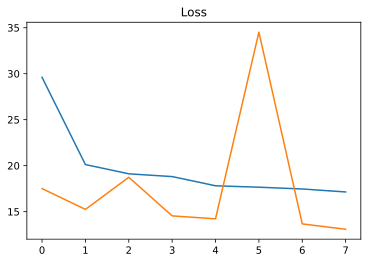

In [83]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [84]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [85]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test_1, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 13.08%


## на шаге 6 результат плачевный 13.08%

In [86]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

Результат с картинками оказался хуже. Использование различных параметров оптимизатора не привели к улучшению. Увеличение BATCH_SIZE в рамках эксперементов, привели к невероятно долгой обработки, что в продакшене не имеет смысла.

## Шаг 7, попробуем блендинг, смешаем catboost и cnn

# Blend

In [98]:
blend_predict_simple = (test_predict_catboost + test_predict_nn1) / 2
print(f"TEST mape: {(mape(y_test_1, blend_predict_simple))*100:0.2f}%")

TEST mape: 57.56%


## Этот вариант на лидерборде показал отличный результат 11.06%, его и оставлю, лучше у меня так и не получилось сделать

In [ ]:
blend_sub_predict_simple = (sub_predict_catboost + sub_predict_nn1) / 2
sample_submission['price'] = blend_sub_predict_simple
sample_submission.to_csv('blend_submission-simple-fin.csv', index=False)